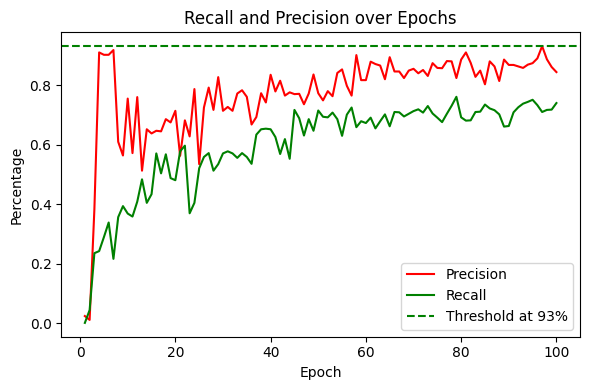

In [27]:
#________________________________ Ploting _______________
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the CSV file in the specified path
df = pd.read_csv('weights/v1/s/1280Augmented+Inversion10%.csv')

plt.figure(figsize=(6, 4))
plt.plot(df['epoch'], df['Precision'], color='red', label='Precision')
plt.plot(df['epoch'], df['Recall'], color='green', label='Recall')
plt.axhline(y=0.93, color='g', linestyle='--', label='Threshold at 93%')

# Adding titles and labels
plt.title('Recall and Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Percentage')

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# _____________________________ count bounding boxes Absolute values ____________________________
import os

def count_small_bboxes(label_dir, threshold=7):
    small_bbox_count = 0

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)

            with open(label_path, 'r') as file:
                for line in file:
                    class_id, x_min, y_min, x_max, y_max = map(int, line.split())
                    if class_id == 1:
                        width, height = x_max - x_min, y_max - y_min

                        if width <= threshold or height <= threshold:
                            small_bbox_count += 1

    return small_bbox_count

# Example usage
label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/1-4_Augm_new'
small_bboxes = count_small_bboxes(label_directory)
print(f"Number of bounding boxes: {small_bboxes}")


In [ ]:
# _____________________________ count bounding boxes Normalized values ____________________________

import os
import cv2

def count_small_bboxes(label_dir, image_dir, threshold=7):
    small_bbox_count = 0

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            image_path = os.path.join(image_dir, os.path.splitext(label_file)[0] + '.png')

            if not os.path.exists(image_path):
                print(f"Image file not found for {label_file}")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Unable to read image: {image_path}")
                continue

            with open(label_path, 'r') as file:
                for line in file:
                    class_id, x_center, y_center, width, height = map(float, line.split())

                    if int(class_id) == 1:
                        abs_width, abs_height = width * image.shape[1], height * image.shape[0]

                        if abs_width <= threshold or abs_height <= threshold:
                            small_bbox_count += 1

    return small_bbox_count

# Example usage
label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_labels'
image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_images'
small_bboxes = count_small_bboxes(label_directory, image_directory)
print(f"Number of bounding boxes: {small_bboxes}")



In [ ]:
# ______________________ Remove bounding boxes below threshold Normalized values ____________________________
import os
import cv2

def remove_small_bboxes(label_dir, image_dir, threshold=7):
    files_modified = []

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            image_path = os.path.join(image_dir, os.path.splitext(label_file)[0] + '.png')

            if not os.path.exists(image_path):
                print(f"Image file not found for {label_file}")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Unable to read image: {image_path}")
                continue

            bboxes = []
            modified = False

            with open(label_path, 'r') as file:
                for line in file:
                    class_id, x_center, y_center, width, height = map(float, line.split())

                    if int(class_id) == 1:
                        abs_width, abs_height = width * image.shape[1], height * image.shape[0]

                        if abs_width > threshold and abs_height > threshold:
                            bboxes.append(line.strip())
                        else:
                            modified = True

            # Rewrite the file if modifications were made
            if modified:
                with open(label_path, 'w') as file:
                    for bbox in bboxes:
                        file.write(bbox + '\n')
                files_modified.append(label_file)

    return files_modified

# Example usage
label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_labels'
image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_images'
files_modified = remove_small_bboxes(label_directory, image_directory)

print(f"Files modified: {len(files_modified)}")
for file in files_modified:
    print(file)


In [ ]:
# _____________________________ printing lables on images with CV (Normalized values) ______________________________

import os
import cv2

def draw_bboxes(image_path, label_path):
    # Define colors for different classes
    colors = {0: (0, 255, 0), 1: (0, 0, 255)}  # 0: Hole (Green), 1: Crack (Red)

    # Read the image
    image = cv2.imread(image_path)

    # Check if image is read
    if image is None:
        print(f"Could not read image: {image_path}")
        return

    # Read the label file and draw boxes
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            # Convert coordinates from normalized YOLO format to absolute coordinates
            x_center, y_center, width, height = x_center * image.shape[1], y_center * image.shape[0], width * image.shape[1], height * image.shape[0]
            x_min, y_min = int(x_center - width / 2), int(y_center - height / 2)
            x_max, y_max = int(x_center + width / 2), int(y_center + height / 2)

            # Draw rectangle on the image
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), colors[int(class_id)], 2)

    # Display the image with bounding boxes
    cv2.imshow('Image with Bounding Boxes', image)
    cv2.waitKey(0)  # Waits for a key press to proceed
    cv2.destroyAllWindows()

def process_directory(images_dir, labels_dir):
    # Process each image and its corresponding label file
    for image_file in os.listdir(images_dir):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            image_path = os.path.join(images_dir, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file)

            if os.path.exists(label_path):
                draw_bboxes(image_path, label_path)
            else:
                print(f"No label file found for {image_file}")

images_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_augmented/test'
labels_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_augmented/test'
process_directory(images_directory, labels_directory)


Processing grid_0.png...


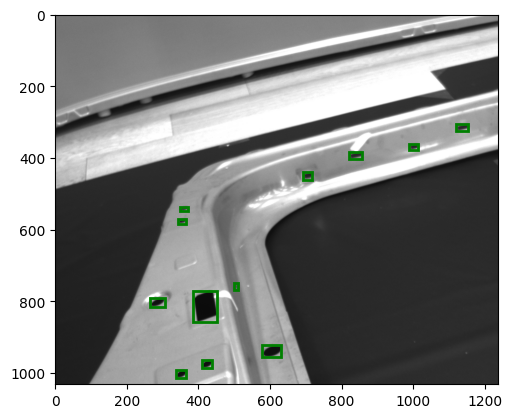

Processing grid_3.png...


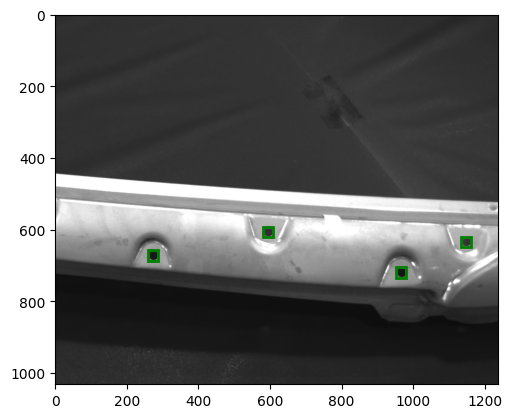

Processing grid_2.png...


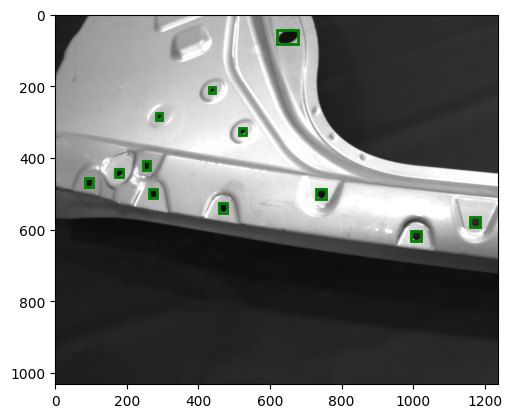

Processing grid_1.png...


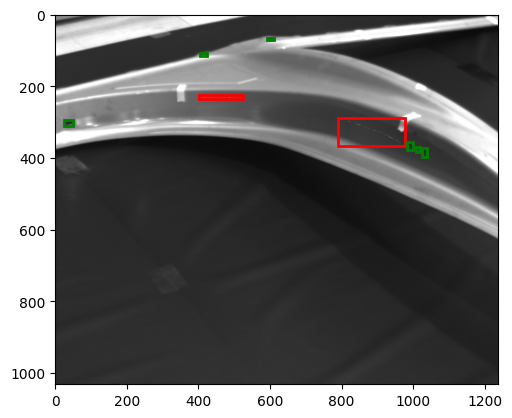

In [1]:
# _____________________________ printing lables on images (Normalized values) ______________________________

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def draw_bboxes(image_path, label_path):
    # Read the image
    image = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Define colors for different classes
    colors = {0: 'green', 1: 'red'}  # 0: Hole, 1: Crack

    # Read the label file and draw boxes
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            # Convert coordinates from normalized YOLO format to matplotlib format
            x_center, y_center, width, height = x_center * image.width, y_center * image.height, width * image.width, height * image.height
            x_min, y_min = x_center - width / 2, y_center - height / 2

            # Create a Rectangle patch and add it to the plot
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=colors[int(class_id)], facecolor='none')
            ax.add_patch(rect)

    # Display the image with bounding boxes
    plt.show()
    plt.close(fig)  # Close the figure to free memory

def process_directory(images_dir, labels_dir):
    # Process each image and its corresponding label file
    for image_file in os.listdir(images_dir):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            image_path = os.path.join(images_dir, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file)

            if os.path.exists(label_path):
                print(f"Processing {image_file}...")
                draw_bboxes(image_path, label_path)
            else:
                print(f"No label file found for {image_file}")

# Example usage
images_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v1/V1_C&H_Shiraz/grid/out/images'
labels_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v1/V1_C&H_Shiraz/grid/out/labels'
process_directory(images_directory, labels_directory)



In [ ]:
# _____________________________ adds a word to the start (prefix) and/or end (suffix)  ______________________________

import os

def add_words_to_filenames(directory, prefix='', suffix=''):
    for filename in os.listdir(directory):
        # Construct the new filename
        new_filename = f"{prefix}{filename}{suffix}"
        # Construct the full old and new file paths
        old_file = os.path.join(directory, filename)
        new_file = os.path.join(directory, new_filename)
        # Rename the file
        os.rename(old_file, new_file)
        print(f"Renamed '{filename}' to '{new_filename}'")

# Example usage
directory_path = '/path/to/your/directory'  # Replace with your directory path
prefix = 'prefix_'  # Replace with your desired prefix, or leave empty for no prefix
suffix = '_suffix'  # Replace with your desired suffix, or leave empty for no suffix
add_words_to_filenames(directory_path, prefix, suffix)


In [14]:
import os
import shutil
import random

def split_dataset(train_img_dir, train_label_dir, val_img_dir, val_label_dir, val_percent=20):
    # Create the validation directories if they don't exist
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)

    # List all image files and corresponding label files
    all_img_files = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Filter out orphaned files (images without labels)
    valid_images = [img for img in all_img_files if os.path.splitext(img)[0] + '.txt' in os.listdir(train_label_dir)]

    # Randomly select a subset of valid images for validation
    num_val_images = int(len(valid_images) * val_percent / 100)
    val_images = random.sample(valid_images, num_val_images)

    moved_images_count = 0
    moved_labels_count = 0

    # Move the selected images and their corresponding label files
    for image in val_images:
        image_path = os.path.join(train_img_dir, image)
        label_path = os.path.join(train_label_dir, os.path.splitext(image)[0] + '.txt')
        shutil.move(image_path, os.path.join(val_img_dir, image))
        shutil.move(label_path, os.path.join(val_label_dir, os.path.splitext(image)[0] + '.txt'))
        moved_images_count += 1
        moved_labels_count += 1
    print(f'number of images moved: {moved_images_count} \n number of labels moved: {moved_labels_count}' )

train_image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v1/V1_C&H_Shiraz/images/train'
train_label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v1/V1_C&H_Shiraz/labels/train/'
validation_image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v1/V1_C&H_Shiraz/images/val/'
validation_label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v1/V1_C&H_Shiraz/labels/val/'

split_dataset(train_image_directory, train_label_directory, validation_image_directory, validation_label_directory)


number of images moved: 30 
 number of labels moved: 30


In [ ]:
#________________________ Rename files ________________________
import os

def rename_files(directory, file_type):
    for i, filename in enumerate(os.listdir(directory)):
        if filename.endswith(file_type):
            new_name = f"v3_{i}{file_type}"
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_name)
            os.rename(old_file, new_file)
            print(f"Renamed '{filename}' to '{new_name}'")

# Example usage:
directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/images'  # Replace with your directory path
file_type = '.png'  # Change to '.jpg', '.png', etc. for images
rename_files(directory_path, file_type)


In [ ]:
#________________________ renames images and their corresponding labels  ________________________
import os

def rename_files(image_dir, label_dir, new_name_base):

    # List of image and label files
    image_files = sorted([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
    label_files = sorted([f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])

    for i, (image_file, label_file) in enumerate(zip(image_files, label_files), start=538):
        # Extract file extensions
        image_ext = os.path.splitext(image_file)[1]
        label_ext = os.path.splitext(label_file)[1]

        # New file names
        new_image_name = f"{new_name_base}_{i}{image_ext}"
        new_label_name = f"{new_name_base}_{i}{label_ext}"

        # Rename files
        os.rename(os.path.join(image_dir, image_file), os.path.join(image_dir, new_image_name))
        os.rename(os.path.join(label_dir, label_file), os.path.join(label_dir, new_label_name))

        print(f"Renamed {image_file} to {new_image_name} and {label_file} to {new_label_name}")

# Example usage
label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_labels'
image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_images'
base_name = '546'

rename_files(image_directory, label_directory, base_name)


In [ ]:
# _________________________ Move files __________________

import os
import shutil

def move_files_starting_with_v1(src_dir, dst_dir):
    # Ensure source directory exists
    if not os.path.exists(src_dir):
        print(f"Source directory {src_dir} does not exist.")
        return

    # Ensure destination directory exists, create if it doesn't
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Iterate through files in the source directory
    for filename in os.listdir(src_dir):
        if filename.startswith("v1_"):
            src_file_path = os.path.join(src_dir, filename)
            dst_file_path = os.path.join(dst_dir, filename)

            # Move the file
            shutil.move(src_file_path, dst_file_path)
            print(f"Moved {filename} to {dst_dir}")

# Example usage
source_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/1-4_Augmentation/images/train' 
destination_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/1-4_Augmentation/images/val' 
move_files_starting_with_v1(source_directory, destination_directory)


In [ ]:
#________________________ copy files ________________________
import os
import shutil

def copy_files(src_dir, dst_dir):

    # Check if the source directory exists
    if not os.path.exists(src_dir):
        print(f"Source directory {src_dir} does not exist.")
        return

    # Create the destination directory if it doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        # print(f"Source directory {dst_dir} does not exist.")
        # return

    # Copy each file from the source directory to the destination directory
    for filename in os.listdir(src_dir):
        if filename.endswith('.png'):
            file_path = os.path.join(src_dir, filename)
            if os.path.isfile(file_path):
                shutil.copy(file_path, dst_dir)
                print(f"Copied {filename} to {dst_dir}")

# Example usage
source_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/addingFiles'
destination_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/labelmeAddingFiles'

copy_files(source_directory, destination_directory)


In [ ]:
#________________________ Remove unmatch(images and it's lables) _________________

import os

def remove_unmatched_files(image_dir, label_dir, image_extensions, label_extension='.txt'):
    # Set of basenames of image and label files (without extensions)
    image_files = {os.path.splitext(file)[0] for file in os.listdir(image_dir) if file.endswith(image_extensions)}
    label_files = {os.path.splitext(file)[0] for file in os.listdir(label_dir) if file.endswith(label_extension)}

    # Remove label files without a corresponding image file
    removed_labels_count = 0
    for label_basename in label_files - image_files:
        os.remove(os.path.join(label_dir, label_basename + label_extension))
        removed_labels_count += 1
        print(f"Removed label: {label_basename + label_extension}")

    # Remove image files without a corresponding label file
    removed_images_count = 0
    for image_basename in image_files - label_files:
        for ext in image_extensions:
            image_path = os.path.join(image_dir, image_basename + ext)
            if os.path.exists(image_path):
                os.remove(image_path)
                removed_images_count += 1
                print(f"Removed image: {image_basename + ext}")
                break  # Break if one of the extensions matched and file was removed

    print(f"Total removed labels: {removed_labels_count}")
    print(f"Total removed images: {removed_images_count}")

# Example usage
image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/backup1023'
label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/backup1023'

remove_unmatched_files(image_directory, label_directory, ('.jpg', '.jpeg', '.png'))


In [ ]:
# ____________________________ Removes a specific word from the filenames ________________
import os

def remove_word_from_filenames(directory, word_to_remove):
    for filename in os.listdir(directory):
        if word_to_remove in filename:
            new_filename = filename.replace(word_to_remove, 'v3_Augmented')
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
            print(f"Renamed '{filename}' to '{new_filename}'")

# Example usage
directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/merged_labels8jan'
word_to_remove = 'v3'  # Replace with the word you want to remove
remove_word_from_filenames(directory_path, word_to_remove)


In [ ]:
# _____________________________ add_prefix_to_filenames ___________________________

import os

def add_prefix_to_filenames(directory, prefix):
    for filename in os.listdir(directory):
        new_filename = prefix + filename
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
        print(f"Renamed '{filename}' to '{new_filename}'")

directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_labels'
prefix = 'v3_Augmented'  # Replace with your desired prefix
add_prefix_to_filenames(directory_path, prefix)


In [ ]:
# ____________________________  Converts .tiff files to .png format (multiprocessing) ________________
from PIL import Image
import os
from multiprocessing import Pool

def convert_and_remove_image(tiff_path):
    directory, filename = os.path.split(tiff_path)
    png_path = os.path.join(directory, os.path.splitext(filename)[0] + '.png')
    
    try:
        with Image.open(tiff_path) as img:
            img.save(png_path)
        
        # Remove the original .tiff file after successful conversion
        os.remove(tiff_path)
        print(f"Converted and removed '{filename}'")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

def convert_tiff_to_png(directory):
    tiff_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.tiff', '.tif'))]
    
    with Pool() as pool:
        pool.map(convert_and_remove_image, tiff_files)

# Example usage
directory_path = '/path/to/your/directory'
convert_tiff_to_png(directory_path)



In [ ]:
# ____________________________  Converts .tiff files to .png format  ________________

from PIL import Image
import os

def convert_tiff_to_png(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.tiff') or filename.endswith('.tif'):
            # Construct file paths
            tiff_path = os.path.join(directory, filename)
            png_path = os.path.join(directory, os.path.splitext(filename)[0] + '.png')

            # Open the tiff file and save it as png
            with Image.open(tiff_path) as img:
                img.save(png_path)
                print(f"Converted '{filename}' to PNG format")

directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/images'
convert_tiff_to_png(directory_path)



In [ ]:
#_____________________ remove files with name ________________

import os
import glob

def remove_files(directory):
    # Construct the pattern to match .json files
    pattern = os.path.join(directory, 'v3_*')

    # Find and remove each .json file
    for file in glob.glob(pattern):
        os.remove(file)
        print(f"Removed {file}")

# Example usage
directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/1-4_Augmentation/images/trai'
remove_files(directory_path)


In [ ]:
# ____________________________  Removing files via extension ________________


import os

def remove_tiff_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.tiff') or filename.endswith('.tif'):
            os.remove(os.path.join(directory, filename))
            print(f"Removed '{filename}'")

directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/images'
remove_tiff_files(directory_path)


In [9]:
## _________________ Match and remove unmatched pics _________________
import os
import shutil

def copy_matched_pngs(dir1, dir2, output_dir):
    # Create a set of .png filenames (without extensions) in each directory
    files1 = {os.path.splitext(f)[0] for f in os.listdir(dir1) if f.endswith('.png')}
    files2 = {os.path.splitext(f)[0] for f in os.listdir(dir2) if f.endswith('.png')}

    # Find matched filenames
    matched_files = files1.intersection(files2)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Copy matched files from dir1 to output_dir
    for file in matched_files:
        shutil.copy(os.path.join(dir1, file + '.png'), os.path.join(output_dir, file + '.png'))
        print(f"Copied: {file + '.png'}")

# Example usage
dir1 = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/images'
dir2 = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3/images/train'
output_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/1-4_Augm_new/mergedCommon'
copy_matched_pngs(dir1, dir2, output_directory)


In [ ]:
# ____________________________  Finding duplicate files  ________________


import os

def check_duplicate_filenames(directory):
    seen = set()
    duplicates = []

    for filename in os.listdir(directory):
        name, ext = os.path.splitext(filename)

        if name in seen:
            duplicates.append(filename)
        else:
            seen.add(name)

    return duplicates

# Example usage
directory_path = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/labels'
duplicates = check_duplicate_filenames(directory_path)

if duplicates:
    print("Found duplicate files:")
    for file in duplicates:
        print(file)
else:
    print("No duplicate files found.")


In [94]:
# ____________________________  Data Correction .txt ___________________________

from PIL import Image
import os

def process_labels(image_dir, label_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            image_file = os.path.splitext(label_file)[0] + '.png'  # Adjust if using a different image format
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, label_file)
            output_path = os.path.join(output_dir, label_file)

            if not os.path.exists(image_path):
                print(f"Image file not found for {label_file}, skipping.")
                continue

            with Image.open(image_path) as img:
                width, height = img.size

                with open(label_path, 'r') as file:
                    lines = file.readlines()

                with open(output_path, 'w') as outfile:
                    for line in lines:
                        if line.strip() != '0, 0, 0, 0':
                            # Remove commas, add label, and split
                            parts = ['1'] + line.replace(',', '').split()

                            # Convert absolute values to normalized values
                            x_min, y_min, x_max, y_max = map(int, parts[1:])
                            x_center = (x_min + x_max) / (2 * width)
                            y_center = (y_min + y_max) / (2 * height)
                            bbox_width = (x_max - x_min) / width
                            bbox_height = (y_max - y_min) / height

                            # Write the normalized line
                            normalized_line = f"1 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n"

                            outfile.write(normalized_line)

# Example usage
image_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/images/'
label_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/labels/'
output_directory ='/hdd/KIA_Smart_Factory_Crack_Hole_detection/Augmentation_crack/v3/shirazChung/labels/normalized_labels_1/'
process_labels(image_directory, label_directory, output_directory)


In [ ]:
# __________________________ Merge labels ___________________________

import os
import shutil

def merge_label_files(dir_cracks, dir_holes, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set of all filenames (without extensions) in each directory
    files_cracks = {os.path.splitext(f)[0] for f in os.listdir(dir_cracks) if f.endswith('.txt')}
    files_holes = {os.path.splitext(f)[0] for f in os.listdir(dir_holes) if f.endswith('.txt')}

    # Merge matched files
    for file in files_cracks & files_holes:
        with open(os.path.join(output_dir, file + '.txt'), 'w') as outfile:
            # Process crack labels
            with open(os.path.join(dir_cracks, file + '.txt'), 'r') as infile:
                for line in infile:
                    if not line.startswith('1 '):
                        line = '1 ' + line
                    outfile.write(line)

            # Process hole labels
            with open(os.path.join(dir_holes, file + '.txt'), 'r') as infile:
                for line in infile:
                    if not line.startswith('0 '):
                        line = '0 ' + line
                    outfile.write(line)

    # # Copy unmatched files from both directories
    # for file in files_cracks - files_holes:
    #     shutil.copy(os.path.join(dir_cracks, file + '.txt'), os.path.join(output_dir, file + '.txt'))

    # for file in files_holes - files_cracks:
    #     shutil.copy(os.path.join(dir_holes, file + '.txt'), os.path.join(output_dir, file + '.txt'))

    print("Merging and copying complete.")

# Example usage
dir_cracks = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/cracks_labels'
dir_holes = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3/labels/train'
output_directory = '/hdd/KIA_Smart_Factory_Crack_Hole_detection/hamza/v3_Augmented/merged_labels_Common8jan'
merge_label_files(dir_cracks, dir_holes, output_directory)


In [3]:
# ______________________________ Convert to .JSON Multiprocessing ____________________________________________
import os
import json
from PIL import Image
import base64
from io import BytesIO
from multiprocessing import Pool

def process_file(args):
    txt_file, txt_dir, img_dir, json_dir, include_img_data = args
    img_file = os.path.splitext(txt_file)[0] + '.jpg'
    img_path = os.path.join(img_dir, img_file)
    json_path = os.path.join(json_dir, os.path.splitext(txt_file)[0] + '.json')

    shapes = []

    with Image.open(img_path) as img:
        img_width, img_height = img.size

        if include_img_data:
            buffered = BytesIO()
            img.save(buffered, format="JPG")
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        else:
            img_str = None

        with open(os.path.join(txt_dir, txt_file), 'r') as file:
            for line in file:
                label, x_center, y_center, width, height = line.split()
                x_center, y_center, width, height = map(float, [x_center, y_center, width, height])
                x_min = (x_center - width / 2) * img_width
                y_min = (y_center - height / 2) * img_height
                x_max = (x_center + width / 2) * img_width
                y_max = (y_center + height / 2) * img_height
                shape = {
                    "label": int(label),
                    "points": [[x_min, y_min], [x_max, y_max]],
                    "group_id": None,
                    "shape_type": "rectangle",
                    "flags": {}
                }
                shapes.append(shape)

        data = {
            "version": "4.5.6",
            "flags": {},
            "shapes": shapes,
            "imagePath": img_file,
            "imageData": img_str,
            "imageHeight": img_height,
            "imageWidth": img_width
        }

        with open(json_path, 'w') as jfile:
            json.dump(data, jfile, indent=2)

    print(f"Processed: {txt_file}")

def txt_to_labelme_json(txt_dir, img_dir, json_dir, include_img_data=True, num_processes=4):
    if not os.path.exists(json_dir):
        os.makedirs(json_dir)

    args = [(file, txt_dir, img_dir, json_dir, include_img_data) for file in os.listdir(txt_dir) if file.endswith('.txt')]
    
    with Pool(num_processes) as pool:
        pool.map(process_file, args)

# Example usage
txt_directory = '/hdd/hamza/'
image_directory = '/hdd/hamza/'
json_directory = '/hdd/hamza/json'
txt_to_labelme_json(txt_directory, image_directory, json_directory, include_img_data=False)  # Set include_img_data to False to skip base64 encoding


Processed: 0312.txt


In [ ]:
# ______________________________ Convert .tiff and .JSON to png and txt Multiprocessing ____________________________________________

import os
import json
from PIL import Image
import multiprocessing

def convert_tiff_to_png(tiff_file, png_dir):
    with Image.open(tiff_file) as img:
        img.save(os.path.join(png_dir, os.path.splitext(os.path.basename(tiff_file))[0] + '.png'))

def convert_json_to_txt(json_file, txt_dir, img_dir):
    with open(json_file, 'r') as file:
        data = json.load(file)
        img_path = os.path.join(img_dir, data["imagePath"])
        with Image.open(img_path) as img:
            img_width, img_height = img.size
            txt_content = []
            for shape in data["shapes"]:
                label = shape["label"]
                # Calculate normalized coordinates (center x, center y, width, height)
                x_min, y_min = shape["points"][0]
                x_max, y_max = shape["points"][1]
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
                txt_content.append(f"{label} {x_center} {y_center} {width} {height}")

    txt_path = os.path.join(txt_dir, os.path.splitext(os.path.basename(json_file))[0] + '.txt')
    with open(txt_path, 'w') as file:
        file.write('\n'.join(txt_content))


    with open(os.path.join(txt_dir, os.path.splitext(os.path.basename(json_file))[0] + '.txt'), 'w') as file:
        file.write(txt_content)

def process_file(file, source_dir, images_dir, labels_dir, img_dir):
    if file.endswith('.tiff'):
        convert_tiff_to_png(os.path.join(source_dir, file), images_dir)
    elif file.endswith('.json'):
        convert_json_to_txt(os.path.join(source_dir, file), labels_dir, img_dir)


def process_directory(source_dir, images_dir, labels_dir, img_dir):
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)

    files = os.listdir(source_dir)
    pool = multiprocessing.Pool()
    tasks = [(file, source_dir, images_dir, labels_dir, img_dir) for file in files]
    pool.starmap(process_file, tasks)

source_directory = 'D:/6pieces'
images_directory = 'D:/6pieces/images'
labels_directory = 'D:/6pieces/labels'
img_directory = 'D:/6pieces'  # path to .tiff images for size reference
process_directory(source_directory, images_directory, labels_directory, img_directory)